In [ ]:
import tensorflow as tf
from transformers import TFAutoModel

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from librosa import resample, load

import os
from IPython.display import Audio


In [ ]:
encoder_ckpt = 'facebook/hubert-base-ls960'
encoder = TFAutoModel.from_pretrained(encoder_ckpt)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!tar -xvf /content/drive/MyDrive/LJSpeech-1.1.tar.bz2

In [ ]:
import os
import pandas as pd

SAMPLE_RATE_ORIG = 22_050
SAMPLE_RATE_DOWN = 16_000

data_path = '/content/LJSpeech-1.1'

metadata = pd.read_csv(
    os.path.join(data_path, 'metadata.csv'),  # Adjusted path here
    sep='|',
    header=None,
    names=['id', 'text', 'text_normalized'])

text_norm_nan = metadata['text_normalized'][metadata.text_normalized.isna()]  # Fixed column selection
text_recovered = text_norm_nan.str.split('|', expand=True)[0]  # Adjusted index here
metadata.loc[metadata.text_normalized.isna(), 'text_normalized'] = text_recovered  # Fixed assignment
metadata['text_normalized'] = metadata.text_normalized.str.lower().str.strip()
metadata['text_normalized'] = '<' + metadata['text_normalized'] + '>'

metadata['audio_path'] = metadata.id.apply(lambda x: os.path.join(data_path, 'wavs', x) + '.wav')

metadata


,id,text,text_normalized,audio_path
0,LJ001-0001,"Printing, in the only sense with which we are ...","<printing, in the only sense with which we are...",/content/LJSpeech-1.1/wavs/LJ001-0001.wav
1,LJ001-0002,in being comparatively modern.,<in being comparatively modern.>,/content/LJSpeech-1.1/wavs/LJ001-0002.wav
2,LJ001-0003,For although the Chinese took impressions from...,<for although the chinese took impressions fro...,/content/LJSpeech-1.1/wavs/LJ001-0003.wav
3,LJ001-0004,"produced the block books, which were the immed...","<produced the block books, which were the imme...",/content/LJSpeech-1.1/wavs/LJ001-0004.wav
4,LJ001-0005,the invention of movable metal letters in the ...,<the invention of movable metal letters in the...,/content/LJSpeech-1.1/wavs/LJ001-0005.wav
...,...,...,...,...
13095,LJ050-0274,made certain recommendations which it believes...,<made certain recommendations which it believe...,/content/LJSpeech-1.1/wavs/LJ050-0274.wav
13096,LJ050-0275,materially improve upon the procedures in effe...,<materially improve upon the procedures in eff...,/content/LJSpeech-1.1/wavs/LJ050-0275.wav
13097,LJ050-0276,"As has been pointed out, the Commission has no...","<as has been pointed out, the commission has n...",/content/LJSpeech-1.1/wavs/LJ050-0276.wav
13098,LJ050-0277,with the active cooperation of the responsible...,<with the active cooperation of the responsibl...,/content/LJSpeech-1.1/wavs/LJ050-0277.wav


In [ ]:
metadata.head(10)

,id,text,text_normalized,audio_path
0,LJ001-0001,"Printing, in the only sense with which we are ...","<printing, in the only sense with which we are...",/content/LJSpeech-1.1/wavs/LJ001-0001.wav
1,LJ001-0002,in being comparatively modern.,<in being comparatively modern.>,/content/LJSpeech-1.1/wavs/LJ001-0002.wav
2,LJ001-0003,For although the Chinese took impressions from...,<for although the chinese took impressions fro...,/content/LJSpeech-1.1/wavs/LJ001-0003.wav
3,LJ001-0004,"produced the block books, which were the immed...","<produced the block books, which were the imme...",/content/LJSpeech-1.1/wavs/LJ001-0004.wav
4,LJ001-0005,the invention of movable metal letters in the ...,<the invention of movable metal letters in the...,/content/LJSpeech-1.1/wavs/LJ001-0005.wav
5,LJ001-0006,"And it is worth mention in passing that, as an...","<and it is worth mention in passing that, as a...",/content/LJSpeech-1.1/wavs/LJ001-0006.wav
6,LJ001-0007,"the earliest book printed with movable types, ...","<the earliest book printed with movable types,...",/content/LJSpeech-1.1/wavs/LJ001-0007.wav
7,LJ001-0008,has never been surpassed.,<has never been surpassed.>,/content/LJSpeech-1.1/wavs/LJ001-0008.wav
8,LJ001-0009,"Printing, then, for our purpose, may be consid...","<printing, then, for our purpose, may be consi...",/content/LJSpeech-1.1/wavs/LJ001-0009.wav
9,LJ001-0010,"Now, as all books not primarily intended as pi...","<now, as all books not primarily intended as p...",/content/LJSpeech-1.1/wavs/LJ001-0010.wav


In [ ]:
train_df, test_df = train_test_split(metadata, test_size=1_000, shuffle=True, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=500, shuffle=True, random_state=42)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11600 entries, 5539 to 2925
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               11600 non-null  object
 1   text             11600 non-null  object
 2   text_normalized  11600 non-null  object
 3   audio_path       11600 non-null  object
dtypes: object(4)
memory usage: 453.1+ KB


In [ ]:
 val_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 6371 to 11340
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               500 non-null    object
 1   text             500 non-null    object
 2   text_normalized  500 non-null    object
 3   audio_path       500 non-null    object
dtypes: object(4)
memory usage: 19.5+ KB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 4347 to 4091
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               1000 non-null   object
 1   text             1000 non-null   object
 2   text_normalized  1000 non-null   object
 3   audio_path       1000 non-null   object
dtypes: object(4)
memory usage: 39.1+ KB


In [ ]:
train_df['text_normalized'].dtype

dtype('O')

In [ ]:
import tensorflow as tf

# Assuming train_df is your DataFrame containing the data
# Check for unexpected float values in 'text_normalized' column and convert them to strings
train_df['text_normalized'] = train_df['text_normalized'].apply(lambda x: str(x) if isinstance(x, float) else x)

# Create TensorFlow Datasets from 'audio_path' and 'text_normalized' columns
train_audio = tf.data.Dataset.from_tensor_slices(train_df['audio_path'])
train_text = tf.data.Dataset.from_tensor_slices(train_df['text_normalized'])

# Zip audio and text datasets together
train_ds = tf.data.Dataset.zip((train_audio, train_text))

In [ ]:
train_audio = tf.data.Dataset.from_tensor_slices(train_df['audio_path'])
train_text = tf.data.Dataset.from_tensor_slices(train_df['text_normalized'])
train_ds = tf.data.Dataset.zip((train_audio, train_text))

In [ ]:
val_audio = tf.data.Dataset.from_tensor_slices(val_df['audio_path'])
val_text = tf.data.Dataset.from_tensor_slices(val_df['text_normalized'])
val_ds = tf.data.Dataset.zip((val_audio, val_text))

In [ ]:
import tensorflow as tf

# Assuming metadata is your DataFrame containing the data
# Check for unexpected float values in 'text_normalized' column and convert them to strings
metadata['text_normalized'] = metadata['text_normalized'].astype(str)

# Create TensorFlow Dataset from the 'text_normalized' column
text_dataset = tf.data.Dataset.from_tensor_slices(metadata['text_normalized'])

In [ ]:
test_audio = tf.data.Dataset.from_tensor_slices(test_df['audio_path'])
test_text = tf.data.Dataset.from_tensor_slices(test_df['text_normalized'])
test_ds = tf.data.Dataset.zip((test_audio, test_text))

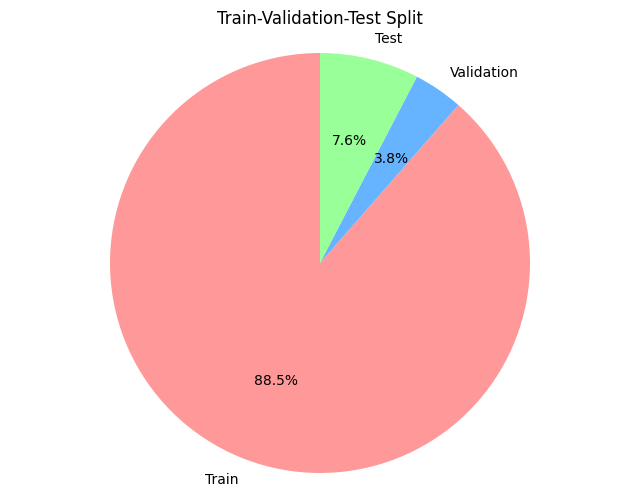

In [ ]:
import matplotlib.pyplot as plt

# Calculate the sizes of train, validation, and test sets
train_size = len(train_df)
val_size = len(val_df)
test_size = len(test_df)

# Define labels for the pie chart
labels = ['Train', 'Validation', 'Test']

# Define sizes for each segment of the pie chart
sizes = [train_size, val_size, test_size]

# Define colors for each segment
colors = ['#ff9999', '#66b3ff', '#99ff99']

# Create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Add a title
plt.title('Train-Validation-Test Split')

# Show the plot
plt.show()


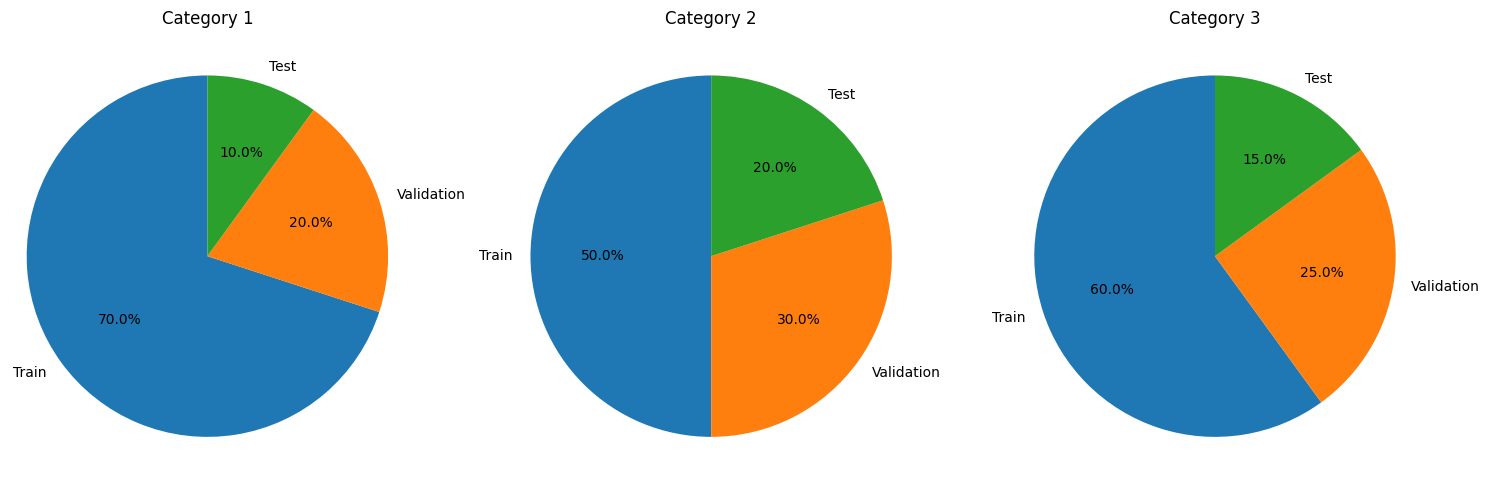

In [ ]:
import matplotlib.pyplot as plt

# Define categories
categories = ['Train', 'Validation', 'Test']

# Define data for each category
data_category1 = [70, 20, 10]  # Example data for category 1
data_category2 = [50, 30, 20]  # Example data for category 2
data_category3 = [60, 25, 15]  # Example data for category 3

# Create subplots for each category
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot pie chart for each category
axs[0].pie(data_category1, labels=categories, autopct='%1.1f%%', startangle=90)
axs[0].set_title('Category 1')

axs[1].pie(data_category2, labels=categories, autopct='%1.1f%%', startangle=90)
axs[1].set_title('Category 2')

axs[2].pie(data_category3, labels=categories, autopct='%1.1f%%', startangle=90)
axs[2].set_title('Category 3')

# Equal aspect ratio ensures that pie is drawn as a circle
for ax in axs:
    ax.axis('equal')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


<ipython-input-29-e7c5298530e8>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=sizes, palette='viridis')


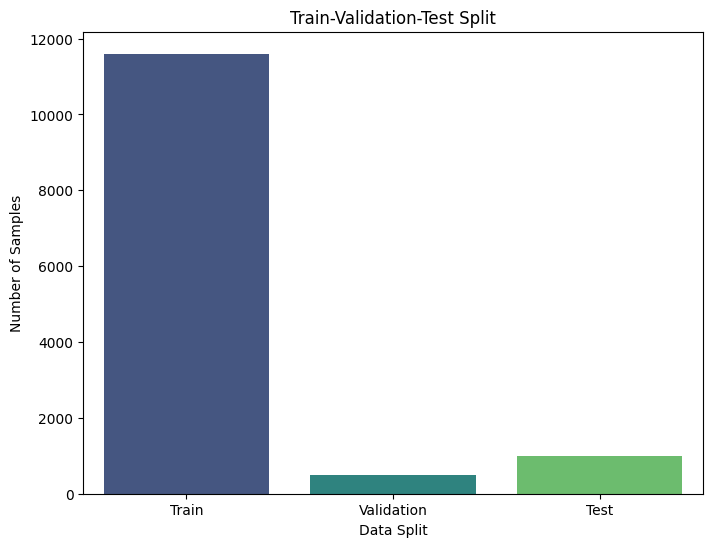

In [ ]:
import seaborn as sns

# Bar Plot
plt.figure(figsize=(8, 6))
sns.barplot(x=labels, y=sizes, palette='viridis')
plt.title('Train-Validation-Test Split')
plt.ylabel('Number of Samples')
plt.xlabel('Data Split')
plt.show()

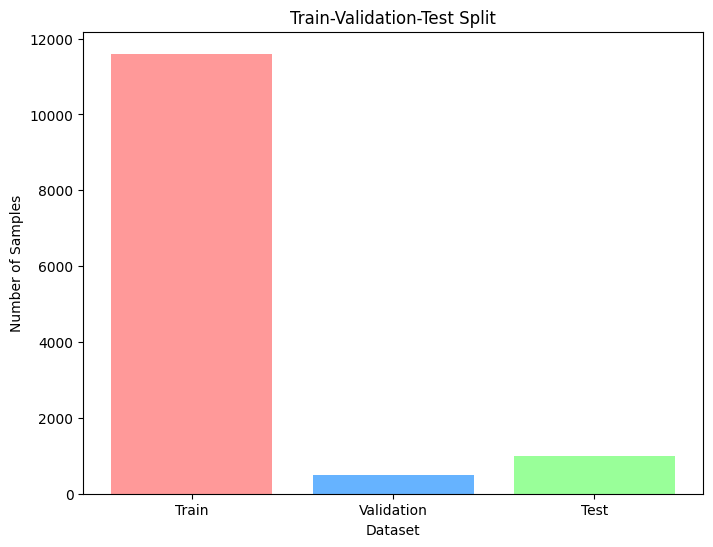

In [ ]:
plt.figure(figsize=(8, 6))
plt.bar(labels, sizes, color=colors)
plt.xlabel('Dataset')
plt.ylabel('Number of Samples')
plt.title('Train-Validation-Test Split')
plt.show()


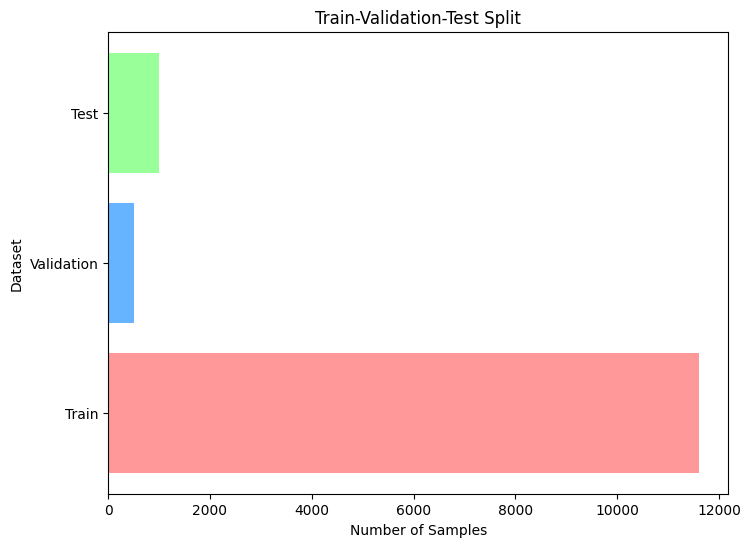

In [ ]:
plt.figure(figsize=(8, 6))
plt.barh(labels, sizes, color=colors)
plt.ylabel('Dataset')
plt.xlabel('Number of Samples')
plt.title('Train-Validation-Test Split')
plt.show()


 decoder preprocessing

In [ ]:
# decoder preprocessing

TEXT_MAXLEN = 200

text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=70,
    standardize=None,
    split='character',
    output_mode='int',
    output_sequence_length=TEXT_MAXLEN+1)

text_vectorizer.adapt(train_df.text_normalized)

vocab = text_vectorizer.get_vocabulary()
vocab_size = text_vectorizer.vocabulary_size()

detokenizer = tf.lookup.StaticHashTable(
    initializer = tf.lookup.KeyValueTensorInitializer(
        keys=range(len(vocab)),
        values=vocab,
        key_dtype=tf.int64),
    default_value='[UNK]')

vocab_size, vocab, detokenizer

(53,
 ['',
  '[UNK]',
  ' ',
  'e',
  't',
  'a',
  'o',
  'n',
  'i',
  's',
  'r',
  'h',
  'd',
  'l',
  'c',
  'f',
  'u',
  'm',
  'w',
  'p',
  'g',
  'y',
  'b',
  ',',
  '>',
  '<',
  'v',
  '.',
  'k',
  'x',
  '-',
  'q',
  'j',
  "'",
  '"',
  ';',
  'z',
  ':',
  ')',
  '(',
  '?',
  '!',
  'ü',
  ']',
  '[',
  '”',
  '“',
  'é',
  '’',
  'ê',
  'è',
  'â',
  'à'],
 <tensorflow.python.ops.lookup_ops.StaticHashTable at 0x7c1ce8855240>)

## Encoder preprocessing

In [ ]:
# encoder preprocessing

AUDIO_MAXLEN = 10*SAMPLE_RATE_DOWN


def load_wav(file_path):
    audio_binary = tf.io.read_file(file_path)
    waveform, _ = tf.audio.decode_wav(audio_binary, desired_channels=1)
    waveform = tf.squeeze(waveform, axis=-1)
    waveform = resample(
        y=waveform.numpy(),
        orig_sr=SAMPLE_RATE_ORIG,
        target_sr=SAMPLE_RATE_DOWN)
    waveform = tf.cast(waveform, tf.float32)[:AUDIO_MAXLEN]

    target_len = AUDIO_MAXLEN
    x_len = tf.shape(waveform)
    num_pads = target_len - x_len
    zero_pads = tf.zeros(shape=(num_pads))
    waveform = tf.concat([waveform, zero_pads], axis=0)
    return waveform


In [ ]:
# building a pipeline with data generators

def generate_audiopaths(data_partition: pd.Series):
    for p in data_partition:
        wav = load_wav(p)
        mean = tf.math.reduce_mean(wav, axis=0, keepdims=True)
        std = tf.math.reduce_std(wav, axis=0, keepdims=True)
        wav = (wav - mean) / std
        yield wav

def generate_texts(data_partition: pd.Series):
    for t in data_partition:
        yield text_vectorizer(t)


path_train = tf.data.Dataset.from_generator(
    generate_audiopaths,
    args=[train_df.audio_path],
    output_signature=(tf.TensorSpec(shape=(AUDIO_MAXLEN), dtype=tf.float32)))
path_val = tf.data.Dataset.from_generator(
    generate_audiopaths,
    args=[val_df.audio_path],
    output_signature=(tf.TensorSpec(shape=(AUDIO_MAXLEN), dtype=tf.float32)))
path_test = tf.data.Dataset.from_generator(
    generate_audiopaths,
    args=[test_df.audio_path],
    output_signature=(tf.TensorSpec(shape=(AUDIO_MAXLEN), dtype=tf.float32)))

text_train = tf.data.Dataset.from_generator(
    generate_texts,
    args=[train_df.text_normalized],
    output_signature=(tf.TensorSpec(shape=(TEXT_MAXLEN+1), dtype=tf.int64)))
text_val = tf.data.Dataset.from_generator(
    generate_texts,
    args=[val_df.text_normalized],
    output_signature=(tf.TensorSpec(shape=(TEXT_MAXLEN+1), dtype=tf.int64)))
text_test = tf.data.Dataset.from_generator(
    generate_texts,
    args=[test_df.text_normalized],
    output_signature=(tf.TensorSpec(shape=(TEXT_MAXLEN+1), dtype=tf.int64)))


train_ds = tf.data.Dataset.zip((path_train, text_train))
val_ds = tf.data.Dataset.zip((path_val, text_val))
test_ds = tf.data.Dataset.zip((path_test, text_test))

In [ ]:
def prepare_data_pipeline(audio, text):
    text_in = text[:-1]
    text_target = text[1:]
    text_target = tf.one_hot(text_target, vocab_size)

    audio = tf.ensure_shape(audio, (AUDIO_MAXLEN))
    text_in = tf.ensure_shape(text_in, (TEXT_MAXLEN))
    text_target = tf.ensure_shape(text_target, (TEXT_MAXLEN, vocab_size))

    return (audio, text_in), text_target

In [ ]:
BATCH_SIZE = 32

train_ds = (train_ds
            .map(prepare_data_pipeline, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE))

val_ds = (val_ds
            .map(prepare_data_pipeline, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE))

test_ds = (test_ds
            .map(prepare_data_pipeline, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE))

train_ds, val_ds, test_ds

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 160000), dtype=tf.float32, name=None), TensorSpec(shape=(None, 200), dtype=tf.int64, name=None)), TensorSpec(shape=(None, 200, 53), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 160000), dtype=tf.float32, name=None), TensorSpec(shape=(None, 200), dtype=tf.int64, name=None)), TensorSpec(shape=(None, 200, 53), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 160000), dtype=tf.float32, name=None), TensorSpec(shape=(None, 200), dtype=tf.int64, name=None)), TensorSpec(shape=(None, 200, 53), dtype=tf.float32, name=None))>)

In [ ]:
train_ds

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 160000), dtype=tf.float32, name=None), TensorSpec(shape=(None, 200), dtype=tf.int64, name=None)), TensorSpec(shape=(None, 200, 53), dtype=tf.float32, name=None))>

In [ ]:
# draw an illustrative sample batch from the pipeline

for ex_processed_batch in train_ds.take(1):
    print(type(ex_processed_batch), type(ex_processed_batch[0]), type(ex_processed_batch[1]))
    (ex_audio, ex_text), ex_target = ex_processed_batch
    print(ex_audio.shape)
    print(ex_text.shape)
    print(ex_target.shape)

<class 'tuple'> <class 'tuple'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(32, 160000)
(32, 200)
(32, 200, 53)


In [ ]:
Audio(ex_audio[0], rate=SAMPLE_RATE_DOWN)

In [ ]:
# sns.lineplot(ex_audio[0])

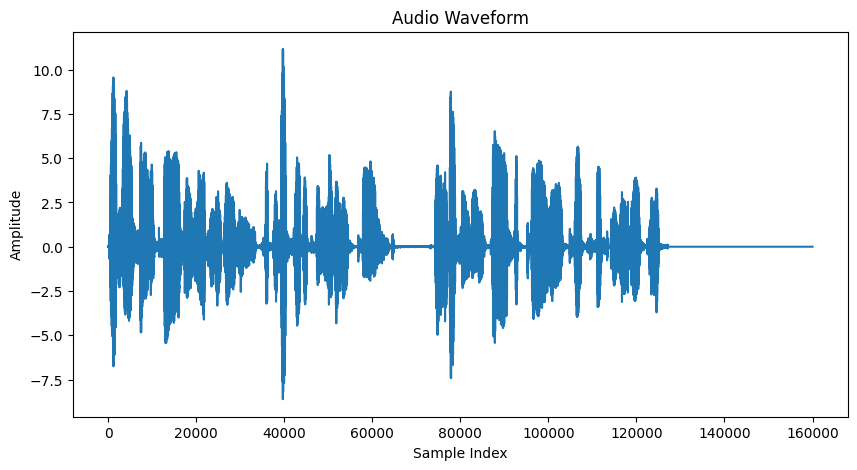

In [ ]:
import matplotlib.pyplot as plt

# Plotting using Matplotlib
plt.figure(figsize=(10, 5))
plt.plot(ex_audio[0].numpy())  # Assuming ex_audio is a TensorFlow tensor
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.title('Audio Waveform')
plt.show()


In [ ]:
ex_encoder_output = encoder(tf.expand_dims(ex_audio[0], axis=0))
ex_encoder_output

TFBaseModelOutput(last_hidden_state=<tf.Tensor: shape=(1, 499, 768), dtype=float32, numpy=
array([[[ 0.10362723,  0.31220096,  0.24610582, ...,  0.03205445,
          0.04107533, -0.36726543],
        [ 0.0963705 , -0.08753408,  0.391715  , ..., -0.14177498,
         -0.19720246,  0.29760036],
        [ 0.03050664, -0.10710411,  0.43060687, ..., -0.02579827,
         -0.35958773,  0.16022164],
        ...,
        [-0.01615785,  0.15192637, -0.04405343, ..., -0.13910328,
         -0.294597  , -0.09767154],
        [ 0.03546112,  0.19252658,  0.01927648, ..., -0.10173486,
         -0.12457274, -0.12694776],
        [ 0.04011992,  0.2052485 ,  0.02816109, ..., -0.10062825,
         -0.08583464, -0.14834407]]], dtype=float32)>, hidden_states=None, attentions=None)

In [ ]:
class AudioExtraction(tf.keras.layers.Layer):
    def __init__(self, extractor, trainable=False):
        super().__init__()
        self.extractor = extractor
        self.trainable = trainable

    @tf.function
    def call(self, inputs):
        features = self.extractor(inputs)
        return features.values().mapping['last_hidden_state']

    def get_config(self):
        config = super().get_config()
        config.update({
            'extractor': self.extractor,
            'trainable': self.trainable
        })


In [ ]:
audio_extraction = AudioExtraction(extractor=encoder)
audio_extraction.trainable

False

In [ ]:
ex_extraction_out = audio_extraction(ex_audio[0:2])
ex_extraction_out

<tf.Tensor: shape=(2, 499, 768), dtype=float32, numpy=
array([[[ 0.10362746,  0.3122005 ,  0.24610607, ...,  0.03205483,
          0.04107497, -0.36726698],
        [ 0.09637091, -0.0875349 ,  0.391715  , ..., -0.14177541,
         -0.19720231,  0.2975991 ],
        [ 0.03050595, -0.1071037 ,  0.4306061 , ..., -0.02579921,
         -0.35958716,  0.16022222],
        ...,
        [-0.01615752,  0.15192634, -0.04405328, ..., -0.13910396,
         -0.29459664, -0.09767181],
        [ 0.03546165,  0.1925253 ,  0.0192758 , ..., -0.10173489,
         -0.12457301, -0.12694773],
        [ 0.04012048,  0.2052482 ,  0.02816104, ..., -0.10062823,
         -0.08583432, -0.14834371]],

       [[-0.00300672,  0.1860559 ,  0.17891644, ...,  0.07804557,
         -0.01703415, -0.06079739],
        [ 0.25419378,  0.11826913,  0.03578828, ..., -0.10626614,
          0.13685484, -0.62779975],
        [-0.04706859,  0.39133972, -0.09853677, ..., -0.16250774,
         -0.09955163, -0.332294  ],
        ...,

##Decoder Side

In [ ]:
class TextEmbedding(tf.keras.layers.Layer):
    def __init__(self, d_model, maxlen):
        super().__init__()
        self.d_model = d_model
        self.maxlen = maxlen
        self.char_embed_layer = tf.keras.layers.Embedding(
            input_dim=vocab_size, output_dim=self.d_model, mask_zero=True)
        self.pos_embed_layer = tf.keras.layers.Embedding(
            input_dim=self.maxlen, output_dim=self.d_model)

    @tf.function
    def call(self, inputs):
        x = inputs
        x = self.char_embed_layer(x)
        pos_tensor = tf.range(0, tf.shape(x)[1])
        pos_embed = self.pos_embed_layer(pos_tensor)
        return x + pos_embed

    def get_config(self):
        config = super().get_config()
        config.update({
            'd_model': self.d_model,
            'maxlen': self.maxlen
        })


In [ ]:
class DecoderAttentionBlock(tf.keras.layers.Layer):
    def __init__(self, num_heads=4, d_model=256, dropout=0.15, ffn_dim=1024):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.dropout = dropout
        self.ffn_dim = ffn_dim
        self.causal_self_attention = tf.keras.layers.MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=self.d_model,
            dropout=self.dropout)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.cross_attention = tf.keras.layers.MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=self.d_model,
            dropout=self.dropout)

        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(self.ffn_dim, activation='relu'),
             tf.keras.layers.Dropout(self.dropout),
             tf.keras.layers.Dense(self.d_model)])

    @tf.function
    def call(self, inputs, encoder_context):
        x = inputs
        self_att_out = self.causal_self_attention(x, x, use_causal_mask=True)
        self_embeds = self.layernorm1(x + self_att_out)
        cross_att = self.cross_attention(self_embeds, encoder_context)
        context_embeds = self.layernorm2(self_embeds + cross_att)
        projections = self.ffn(context_embeds)
        block_output = self.layernorm3(context_embeds + projections)
        return block_output

    def get_config(self):
        config = super().get_config()
        config.update({
            'num_heads': self.num_heads,
            'd_model': self.d_model,
            'dropout': self.dropout,
            'ffn_dim': self.ffn_dim
        })
        return config

##FULL MODEL


In [ ]:
from tensorflow.keras.layers import Input, Dense

In [ ]:
decoder_in = Input(shape=(None,), name='decoder_text_input') #200
encoder_in = Input(shape=(160000,), name='encoder_audio_input') #160000

audio_features = AudioExtraction(extractor=encoder)(encoder_in)
text_embeds = TextEmbedding(d_model=256, maxlen=200)(decoder_in)

text_embeds = DecoderAttentionBlock(
    num_heads=6, d_model=256, dropout=0.15, ffn_dim=1024)(text_embeds, audio_features)
text_embeds = DecoderAttentionBlock(
    num_heads=6, d_model=256, dropout=0.15, ffn_dim=1024)(text_embeds, audio_features)

logits = Dense(vocab_size)(text_embeds)

transformer = tf.keras.Model(inputs=[encoder_in, decoder_in], outputs=[logits])
transformer.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 decoder_text_input (InputL  [(None, None)]               0         []                            
 ayer)                                                                                            
                                                                                                  
 encoder_audio_input (Input  [(None, 160000)]             0         []                            
 Layer)                                                                                           
                                                                                                  
 text_embedding (TextEmbedd  (None, None, 256)            64768     ['decoder_text_input[0][0]']  
 ing)                                                                                         

In [ ]:
# test a forward pass
ex_model_output = transformer((ex_audio[:2], ex_text[:2]))
ex_model_output


<tf.Tensor: shape=(2, 200, 53), dtype=float32, numpy=
array([[[ 2.1697142 , -1.4682146 , -2.650078  , ...,  0.03888071,
          0.50677574, -1.0826765 ],
        [-2.2737956 , -0.77784973,  0.11936972, ...,  0.29552525,
         -0.13283035,  1.1103519 ],
        [-1.3142362 , -1.0027122 , -0.6948576 , ...,  1.5774635 ,
         -0.7668486 , -3.5945787 ],
        ...,
        [ 1.905575  , -0.32028684, -1.695232  , ...,  1.8361804 ,
         -0.8517198 ,  1.1032226 ],
        [ 0.8858937 , -2.682046  ,  1.439254  , ...,  0.6962131 ,
         -0.23324789,  1.4059603 ],
        [-0.08638841, -3.4757726 ,  0.62435067, ...,  0.18517381,
         -0.709407  , -0.7789406 ]],

       [[ 2.167239  , -1.4729133 , -2.6579227 , ...,  0.04675245,
          0.5167146 , -1.0864167 ],
        [-0.7755349 , -0.11207755, -1.3355966 , ...,  0.5246099 ,
         -0.79311746,  0.6780497 ],
        [-0.92557716, -2.187588  ,  0.21588111, ...,  0.92781794,
         -0.49030483, -0.9498713 ],
        ...,


In [ ]:
# decode model outputs

def decode_model_outputs(logits):
    token_preds = tf.argmax(logits, axis=-1)
    char_preds = detokenizer.lookup(token_preds)
    char_preds = tf.transpose(char_preds, perm=[1, 0])
    string_preds = tf.strings.join(char_preds)
    string_preds  = tf.strings.split(string_preds, '>', maxsplit=1).to_tensor()
    return string_preds[:, 0]

ex_outputs_decoded = decode_model_outputs(ex_model_output)
ex_outputs_decoded


<tf.Tensor: shape=(2,), dtype=string, numpy=
array([b'c;le?rz\'wzwjjriuwej,jewgyjuvw,:jf,x;u(fuci?jcqwu;u,guj[\xc3\xa9ypecrgi;wztgi"jguj?hifuji!uc\xe2\x80\x99?zzek?urt;:kr;<r:gux\xc3\xa9);cqe?rc:::::j::r):::::::::,djc:z:j\xc3\xa8\xc3\xa0::::g:::j\xc3\xa9:::::j::gj:::jgjdrd:::;::j:::::::\xc3\xa0::):::jj::,',
       b'c;ec\xc3\xaa'], dtype=object)>

In [ ]:
print(ex_outputs_decoded[0].numpy())
print()

ex_targets_decoded = decode_model_outputs(ex_target)
print(ex_targets_decoded[0].numpy())

b'c;le?rz\'wzwjjriuwej,jewgyjuvw,:jf,x;u(fuci?jcqwu;u,guj[\xc3\xa9ypecrgi;wztgi"jguj?hifuji!uc\xe2\x80\x99?zzek?urt;:kr;<r:gux\xc3\xa9);cqe?rc:::::j::r):::::::::,djc:z:j\xc3\xa8\xc3\xa0::::g:::j\xc3\xa9:::::j::gj:::jgjdrd:::;::j:::::::\xc3\xa0::):::jj::,'

b'there had been a pause in legislation, except of a permissive kind. the second and third victoria, cap. fifty-six'


In [ ]:
detokenizer.lookup(tf.argmax(ex_target[0], axis=-1))

<tf.Tensor: shape=(200,), dtype=string, numpy=
array([b't', b'h', b'e', b'r', b'e', b' ', b'h', b'a', b'd', b' ', b'b',
       b'e', b'e', b'n', b' ', b'a', b' ', b'p', b'a', b'u', b's', b'e',
       b' ', b'i', b'n', b' ', b'l', b'e', b'g', b'i', b's', b'l', b'a',
       b't', b'i', b'o', b'n', b',', b' ', b'e', b'x', b'c', b'e', b'p',
       b't', b' ', b'o', b'f', b' ', b'a', b' ', b'p', b'e', b'r', b'm',
       b'i', b's', b's', b'i', b'v', b'e', b' ', b'k', b'i', b'n', b'd',
       b'.', b' ', b't', b'h', b'e', b' ', b's', b'e', b'c', b'o', b'n',
       b'd', b' ', b'a', b'n', b'd', b' ', b't', b'h', b'i', b'r', b'd',
       b' ', b'v', b'i', b'c', b't', b'o', b'r', b'i', b'a', b',', b' ',
       b'c', b'a', b'p', b'.', b' ', b'f', b'i', b'f', b't', b'y', b'-',
       b's', b'i', b'x', b'>', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b

##Compilation: Loss Function, Metric, Callbacks, Learning Rate Schedule

In [ ]:
class MaskedLoss(tf.keras.losses.Loss):
    def __init__(self, name='masked_loss'):
        super(MaskedLoss, self).__init__(name=name)
        self.loss_object = tf.keras.losses.CategoricalCrossentropy(
            from_logits=True, reduction='none', label_smoothing=0.1)

    def call(self, label, pred):
        mask = tf.argmax(label, axis=-1) != 0

        loss = self.loss_object(label, pred)
        mask = tf.cast(mask, dtype=loss.dtype)

        loss *= mask
        loss_reduction = tf.reduce_sum(loss) / tf.reduce_sum(mask)
        return loss_reduction

In [ ]:
class MaskedAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='masked_accuracy', **kwargs):
        super(MaskedAccuracy, self).__init__(name=name, **kwargs)
        self.match_metric = self.add_weight(name='match_metric', initializer='zeros')
        self.mask_metric = self.add_weight(name='mask_metric', initializer='zeros')

    def update_state(self, label, pred, sample_weight=None):
        pred = tf.argmax(pred, axis=-1)
        label = tf.argmax(label, axis=-1)
        label = tf.cast(label, pred.dtype)
        _match = label == pred

        mask = label != 0

        _match = _match & mask

        _match = tf.cast(_match, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)

        self.match_metric.assign_add(tf.reduce_sum(_match))
        self.mask_metric.assign_add(tf.reduce_sum(mask))

    def result(self):
        return self.match_metric / self.mask_metric

    def reset_state(self):
        self.match_metric.assign(0.0)
        self.mask_metric.assign(0.0)

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model_int = d_model
        self.d_model = tf.cast(self.d_model_int, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        config = {"d_model": (self.d_model_int), "warmup_steps": self.warmup_steps}
        return config
class CustomModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, freq, file_path):
        super().__init__()
        self.freq = freq
        self.file_path = file_path

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.freq == 0:
            print('\n-------SAVING MODEL CHECKPOINT-------\n')
            tf.saved_model.save(transformer, f'TrainingCheckpoint_{epoch+1}')
            print(f'\n-------CHECKPOINT FOR EPOCH {epoch+1} SUCCESSFUL-------\n')
class PredictionMonitor(tf.keras.callbacks.Callback):
    def __init__(self, data_sample, freq):
        super().__init__()
        self.data_sample = data_sample
        self.freq = freq


    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.freq == 0:
            print('\n------- MONITORING -------\n')

            (audio_in, text_in), text_target = self.data_sample
            logits = transformer((audio_in, text_in))
            text_preds = decode_model_outputs(logits)
            for i, pred in enumerate(text_preds):
                print(f'PRED_{i}: ', pred.numpy())
                print(f'TARGET_{i}', decode_model_outputs(tf.expand_dims(text_target[i], 0))[0].numpy())
transformer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=CustomSchedule(d_model=256)),
    loss=MaskedLoss(),
    metrics=[MaskedAccuracy()])


##Model Training


In [ ]:
# instantiate all call backs

for (monitor_audio, monitor_text), monitor_target in val_ds.take(1):
    pass

monitor = PredictionMonitor(
            data_sample=((monitor_audio[:4], monitor_text[:4]), monitor_target[:4]),
            freq=3)

checkpoints = CustomModelCheckpoint(freq=5, file_path='TrainingCheckpoint')

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_masked_acc',
    mode='max',
    min_delta=0.001,
    restore_best_weights=True,
    patience=3)

In [ ]:
transformer.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[monitor, checkpoints, early_stop])

tf.saved_model.save(transformer, 'DecoderTrainingOutput')


In [ ]:
# inspect training history, plot the loss and accuracy curves

training_history = pd.DataFrame(transformer.history.history)
training_history.to_csv('training_history.csv')
training_history


,loss,masked_accuracy,val_loss,val_masked_accuracy
0,3.097745,0.232020,2.712591,0.289198
1,2.612919,0.319651,2.402672,0.391561
2,2.166986,0.474794,1.891010,0.578571
3,1.623116,0.674857,1.431014,0.745552
4,1.310694,0.792261,1.246390,0.814779
5,1.173290,0.843368,1.161448,0.846164
6,1.095779,0.871608,1.096650,0.870355
7,1.043197,0.890643,1.065748,0.880914
8,1.004964,0.904351,1.032879,0.893709
9,0.976266,0.914295,1.014642,0.899971


<Axes: ylabel='masked_accuracy'>

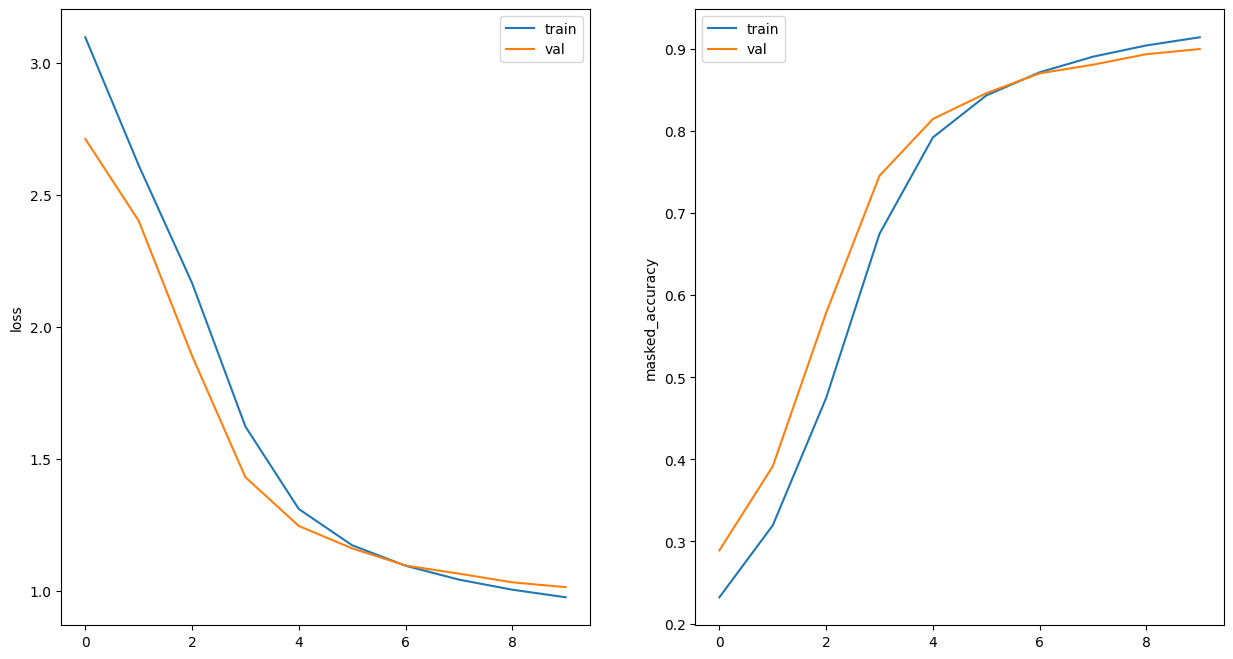

In [ ]:
plt.rcParams['figure.figsize'] = (15, 8)
fig, (ax1, ax2) = plt.subplots(1, 2)

sns.lineplot(training_history.loss, label='train', ax=ax1)
sns.lineplot(training_history.val_loss, label='val', ax=ax1)

sns.lineplot(training_history.masked_accuracy, label='train', ax=ax2)
sns.lineplot(training_history.val_masked_accuracy, label='val', ax=ax2)

In [ ]:
# evaluate on test set
transformer.evaluate(test_ds)

32/32 [==============================] - 80s 2s/step - loss: 1.0174 - masked_accuracy: 0.8997


[1.0174444913864136, 0.8996564149856567]

In [ ]:
# reload the model artefact
model = tf.saved_model.load('DecoderTrainingOutput')
model

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x78d823b3d030>

In [ ]:
# get some examples from the test dataset

for (test_audio, test_text), test_target in test_ds.take(1):
    print(test_audio.shape)
    print(test_text.shape)
    print(test_target.shape)

(32, 160000)
(32, 200)
(32, 200, 53)


In [ ]:
test_target_decoded = decode_model_outputs(test_target)
print(test_target_decoded[5].numpy())
Audio(test_audio[5], rate=SAMPLE_RATE_DOWN)

b'this price included nineteen dollars, ninety-five cents for the rifle and the scope, and one dollar, fifty cents for postage and handling.'


In [ ]:
# @title
!pip install gtts

In [ ]:
# @title
from gtts import gTTS as DecoderTrainingOutput
from IPython.display import Audio

In [ ]:
# Text to be converted to speech
text = "Hello Sir, how are you today?"

speech = DecoderTrainingOutput(text=text, slow=False)
# Save the speech audio to an MP3 file
output_file = "output.mp3"
speech.save(output_file)

# Play the speech audio in the Colab notebook
Audio(output_file)


##Streamlit UI

In [ ]:
!pip install  streamlit

In [ ]:
import streamlit as st
import tensorflow as tf
from transformers import TFAutoModel
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from librosa import resample, load
from IPython.display import Audio

In [ ]:
!wget -q -O - ipv4.icanhazip.com

34.105.118.82


In [ ]:
!pip install pydub

In [ ]:
! streamlit run main.py & npx localtunnel --port 8501